# Boundary Equilibrimum infoGANs for Fault Detection example

## 초기 설정들

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="1"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None

file_name = 'ex_BE_infoGANs_for_FD_v3'



test_normal_data :  (5139, 64, 64, 1)
test_anomalous_data :  (4861, 64, 64, 1)
train_normal_data :  (28038, 64, 64, 1)
train_anomalous_data :  (26962, 64, 64, 1)


## network load

In [2]:
if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
c = sess.graph.get_tensor_by_name("c:0")
u = sess.graph.get_tensor_by_name("u:0")
k = sess.graph.get_tensor_by_name("k:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

G_sample = sess.graph.get_tensor_by_name("G_sample:0")
E_z = sess.graph.get_tensor_by_name("E_z:0")
E_c = sess.graph.get_tensor_by_name("Reshape:0")



re_image = sess.graph.get_tensor_by_name("re_image:0")
re_z = sess.graph.get_tensor_by_name("re_z:0")
re_c = sess.graph.get_tensor_by_name("Reshape_1:0")

re_z_loss = sess.graph.get_tensor_by_name("re_z_loss:0")
re_c_loss = sess.graph.get_tensor_by_name("re_c_loss:0")
re_image_loss = sess.graph.get_tensor_by_name("re_image_loss:0")


E_loss = sess.graph.get_tensor_by_name("E_loss:0")

D_real = sess.graph.get_tensor_by_name('D_real:0')                       # D(x)
D_fake = sess.graph.get_tensor_by_name('D_fake:0')         # D(G(z))
Q_fake = sess.graph.get_tensor_by_name("Q_fake:0")


D_enc = sess.graph.get_tensor_by_name("D_enc_1:0")

D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
Q_loss  = sess.graph.get_tensor_by_name("Q_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")
E_optim = sess.graph.get_operation_by_name("E_optim")
E_AE_optim = sess.graph.get_operation_by_name("E_AE_optim")




INFO:tensorflow:Restoring parameters from ex_BE_infoGANs_for_FD_v3/para.cktp


In [3]:
train_epoch = 15
batch_size = 100
z_size = 100
lam = 0.001
gamma = 0.5
k_curr = 0.0
c_size = 10


file_name1 = 'test3_BE_infoGANs_for_FD'


if not os.path.isdir(file_name1) :
    os.mkdir(file_name1)

In [4]:
np.random.seed(int(time.time()))


one_hot = np.eye(c_size)
temp2 = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
test_c = one_hot[temp2].reshape([-1,1,1,c_size])
test_z = np.random.uniform(-1,1,size=(16,1,1,z_size))
mnist_4by4_save(np.reshape(test_normal_data[0:16],(-1,64,64,1)),file_name1 + '/normal.png')    
mnist_4by4_save(np.reshape(test_anomalous_data[0:16],(-1,64,64,1)),file_name1 + '/anomalous.png')    

E_error = []
start = time.time()
for epoch in range(train_epoch) :

    np.random.seed(int(time.time()))
    train_normal_data = idx_shuffle(train_normal_data) 

    for iteration in range(train_normal_data.shape[0] // batch_size) : 


        train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
        u_ = np.reshape(train_images,(-1,64,64,1)) 
        z_ = np.random.uniform(-1,1,size=(batch_size,1,1,z_size))
        temp1 = np.random.randint(0,10,(batch_size))                                                                                                                                     
        c_ = one_hot[temp1].reshape([-1,1,1,c_size])
        
        _  = sess.run([E_optim], {u : u_, z : z_, c : c_,isTrain : True})
        
        _ , E_e = sess.run([E_AE_optim, re_image_loss], {u : u_, z : z_, c : c_,isTrain : True})
        E_error.append(E_e)
        
            


    r = sess.run([re_image],feed_dict={u : test_normal_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/normal_{}.png'.format(str(epoch).zfill(3)))

    r = sess.run([re_image],feed_dict={u : test_anomalous_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/anomlous_{}.png'.format(str(epoch).zfill(3)))

    print("E_e : %.6f"%(np.mean(E_error)))
    E_error = []

saver = tf.train.Saver()
saver.save(sess,file_name1 + '/para.cktp')

end = time.time()-start

print("total time : ",end)

E_e : 32.816357
E_e : 32.256104
E_e : 31.970041
E_e : 32.232952
E_e : 31.712790
E_e : 31.627253
E_e : 31.809326
E_e : 31.906641
E_e : 31.890301
E_e : 32.089027
E_e : 31.406752
E_e : 31.701080
E_e : 31.681061
E_e : 31.784075
E_e : 31.766197
total time :  1506.29243850708


array([[ 0.75167322]], dtype=float32)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
feature = []
cosine = []


for iteration in range(test_normal_data.shape[0] // batch_size) : 
    test_images = test_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
  
    for i in range(batch_size) :
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        feature.append(feature_e)
        cosine.append(feature_cosine)


    

In [6]:
afeature = []
acosine = []


for iteration in range(test_anomalous_data.shape[0] // batch_size) : 
    test_images = test_anomalous_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
    
    for i in range(batch_size) :
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        afeature.append(feature_e)
        acosine.append(feature_cosine)

    



In [7]:
train_feature = []
train_cosine = []


for iteration in range(train_normal_data.shape[0] // batch_size) : 
    test_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
  
    for i in range(batch_size) :
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        train_feature.append(feature_e)
        train_cosine.append(feature_cosine)

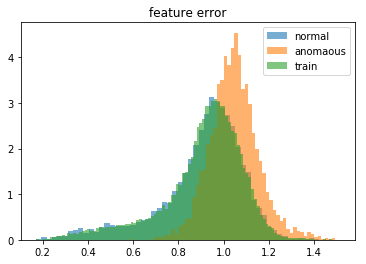

In [8]:


import matplotlib.pyplot as plt


plt.hist(np.reshape(feature,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("feature error")



plt.hist(np.reshape(afeature,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_feature,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    

  

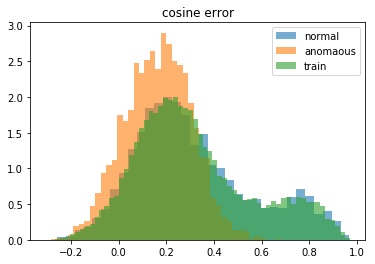

In [9]:
plt.hist(np.reshape(cosine,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("cosine error")

plt.hist(np.reshape(acosine,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_cosine,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()  

In [74]:
from sklearn.metrics.pairwise import cosine_similarity


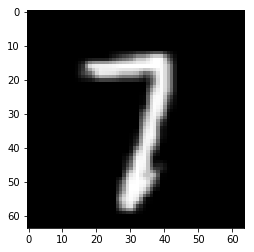

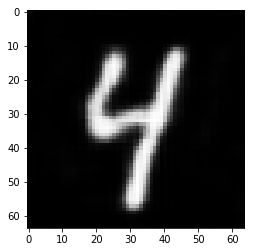

[[[[  1.07503219e-28   0.00000000e+00   0.00000000e+00   0.00000000e+00
      2.14057310e-31   0.00000000e+00   0.00000000e+00   0.00000000e+00
      8.68816169e-36   1.00000000e+00]]]] [[  3.98396514e-06   2.20910465e-06   1.34181425e-06   5.44409777e-05
    9.34806158e-05   1.77756174e-05   1.85025158e-07   1.21335185e-03
    1.52682458e-06   9.98611689e-01]]
0.152384 0.749366 [[ 0.91430855]] [[ 0.47626606]]


In [104]:


im =  test_anomalous_data[111]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)

In [76]:
im_enc

[array([[[[-0.64330131, -1.07335508,  3.09616661,  1.88346589,  0.79869056,
           -0.33810547,  1.2695843 , -0.98340863,  0.21326867, -1.34443784,
            2.21015692,  0.16688631,  1.19680619, -1.01797807, -0.00899344,
            0.43866125,  1.08744943, -0.46885082,  0.98144197,  1.39461386,
            0.83510065, -0.85343528, -0.4139488 , -1.31586826,  1.06155157,
           -0.13298434, -0.39008003,  0.54946494, -0.36116496, -1.43561828,
           -0.85611755,  0.18804875,  0.61389804,  1.43240285,  0.31361794,
           -0.26973405, -0.99250132,  1.45454168, -0.29797408, -0.25936598,
            1.08269513,  1.42855453,  1.58365345,  2.09074402, -0.94717747,
            0.83973396,  0.58276188, -0.69290882, -1.46487665, -0.05009381,
           -0.90483165, -2.25753379, -1.04863286,  0.26355904, -0.82327533,
           -0.08397249, -0.30958951,  0.38862565, -2.05447412, -0.45075804,
           -0.39915991, -0.13019641,  1.90679169, -0.88235927,  1.17833638,
            

In [77]:
im_re_enc

array([[[[-0.88167173, -0.47838661,  0.97080672,  0.41897887, -0.51601774,
          -0.03565793,  0.46633065,  0.67933583,  0.22824095, -1.19912624,
           0.90824533, -0.91070569, -0.99108416, -0.30911991,  0.36635077,
           0.92729878,  0.42510635,  0.44120246,  0.09522473,  1.66041291,
           0.98284602,  0.84811872,  0.06451426, -0.25231373, -0.54249716,
          -0.96819144,  0.74750715,  0.87951934,  0.73489887, -0.78016281,
          -0.65559441,  0.14689623,  1.33041191,  0.47905725, -1.51827323,
           0.20341301, -0.33562282, -0.57989943, -0.42445692,  0.82146692,
           0.27795294, -0.61299497,  0.9907425 ,  0.6294502 , -0.25431648,
          -0.25661266, -1.17466807,  0.31850073, -1.68194735,  1.44399679,
          -0.37547922, -0.35185614,  0.23959364, -0.31805101, -0.18322591,
          -1.58122981, -0.3949663 ,  0.95481849, -1.83542144, -0.69051844,
           1.16937757, -0.65209371,  0.56770295, -0.84848207,  1.20790875,
           0.56392723,  0

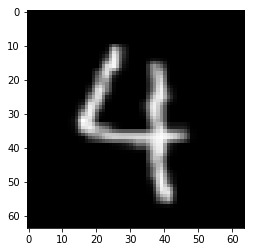

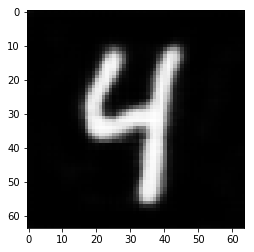

[[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.06120913e-31
      0.00000000e+00   1.09979096e-36   0.00000000e+00   7.59112499e-18
      0.00000000e+00   1.00000000e+00]]]] [[  2.34717357e-09   8.34257463e-09   2.19057181e-08   4.33114883e-06
    2.63901734e-06   1.65162510e-06   5.68424952e-09   3.50582440e-07
    8.34520364e-08   9.99990821e-01]]
0.140228 0.718534 [[ 0.92405862]] [[ 0.53316969]]


In [107]:
im =  test_normal_data[11]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')

plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)


In [108]:
im_enc

[array([[[[-1.0442009 , -1.2174989 ,  0.78466833, -0.06493638, -0.42672884,
           -0.02165738, -0.05761369, -0.14354043,  1.95414138, -0.03972762,
            1.7519052 ,  0.69944096, -0.137216  ,  2.73255587,  0.57894844,
            0.13307145, -2.72707748,  0.7887392 , -0.46772271,  0.36753005,
            0.99045557,  1.08381224, -2.04231787, -0.28952855,  1.16511881,
           -0.09269818,  0.21882159, -1.38667035, -1.5240593 , -0.15768303,
           -0.37698126, -0.08693676, -0.52939802,  0.31267899, -0.78428346,
           -0.70939583,  0.51934546, -0.47691047,  0.48383945, -0.86951733,
           -0.59379929,  0.84701878,  2.15388775, -1.01329422, -1.48119771,
           -0.47108242, -0.53680354,  1.26883519, -1.9925276 ,  0.04763317,
           -0.40418774,  0.25088447,  0.21704571,  0.42381671,  0.2439028 ,
            0.01956891, -0.08416337, -0.36871439,  0.38290477, -0.18850632,
           -0.83704424,  1.67133176,  0.0206124 , -0.80822062,  0.16582556,
           -

In [62]:
im_re_enc

array([[[[ 0.1514827 , -1.73705161,  0.52878952, -0.26899302, -0.78680176,
          -1.62515593, -1.29692125, -0.26600212, -0.11160326, -0.40646294,
           1.17891037,  0.73167515, -0.25412643,  0.45711863,  2.24698138,
           0.13331503, -1.04749596, -0.54755634,  0.02332181,  0.81080586,
          -0.40863806,  0.70400774, -0.0570921 ,  0.54057407,  1.48574543,
           1.50982797,  0.45173204, -0.73856127, -0.99792892,  0.72820026,
           0.89937109, -0.42155895,  0.48322028,  2.70137525, -0.122012  ,
          -0.07574479,  0.13852282, -0.06618971, -0.25236696, -0.010827  ,
          -0.78373206, -0.51174581,  1.21372986,  0.1668032 , -0.49213141,
           0.50222182,  0.40120843, -1.23369932, -0.43447611, -0.15583466,
          -0.00430887,  0.16617599, -0.55016851,  1.10362005, -0.41871378,
          -0.39123785,  1.24991417,  0.21686901, -0.40791848,  0.35970661,
           0.96574777,  0.34319532, -0.47307238,  0.76584947, -1.32688725,
          -0.43664825, -2

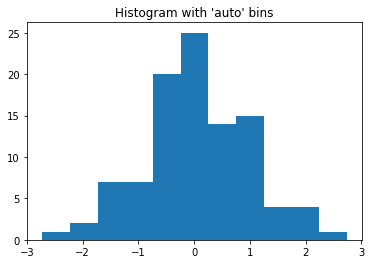

In [110]:
import matplotlib.pyplot as plt

plt.hist(np.reshape(im_enc,-1), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
